In [34]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import os.path

if not os.path.isfile('models.py'):
    from google.colab import drive
    drive.mount('/content/drive')

!pip install pandas_summary
#!pip install --upgrade pandas

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.youtube.com/watch?v=1-NYPQw5THU&feature=youtu.be

## CARGA DE DATOS

In [35]:
googleDrivePath = '/content/drive/MyDrive/TRABAJO/Data Science/ITBA-DeepLearning/Notebooks/Competencias/10-1-Rossman'

In [36]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import load_model

In [37]:
if not os.path.isfile('models.py'):
    df = pd.read_feather(googleDrivePath+'/train_normalized_data2.fth')
    df_test = pd.read_feather(googleDrivePath+'/test_normalized_data2.fth')
else:
    df = pd.read_feather('train_normalized_data2.fth')
    df_test = pd.read_feather('test_normalized_data2.fth')

### DEFINICION DE FEATURES Y OUTPUS

In [38]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks',           'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 
'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool'] 

y_out_columns = ['Sales']

### SPLIT DE DATASET

In [39]:
# split_type = 'random'
#split_type = 'no_split'
split_type = 'last_week'

In [40]:
# Esta es para entrenar con todo
if split_type == 'no_split':
    df_train = df
elif split_type == 'last_week':
    # Esto divide en train y val, como venimos haciendo
    df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
    df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
    print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')
elif split_type == 'random':
    # Splitting aleatorio
    np.random.seed(42)
    indexes = np.arange(len(df))
    np.random.shuffle(indexes)
    N = len(df)//5
    df_train = df[N:]
    df_val = df[:N]
    print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')


#df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
#df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
#print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [41]:
X_train = df_train[cat_vars + contin_vars]
if split_type != 'no_split':
    X_val = df_val[cat_vars + contin_vars]
X_test = df_test[cat_vars + contin_vars]

In [ ]:
def predicctionDesNormalizacion(model, soloVal=False):
  

  if log_output:
      if soloVal:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)
      else:
        y_pred_train = np.exp(model.predict(X_train, verbose=1)*max_log_y)
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)
  else:
      if soloVal:
        y_pred = model.predict(X_val, verbose=1)*y_std + y_mean
      else:
        y_pred_train = model.predict(X_train, verbose=1)*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)*y_std + y_mean
        y_pred_test = model.predict(X_test, verbose=1)*y_std + y_mean
  if soloVal:
    return y_pred
  return y_pred_train, y_pred, y_pred_test



### PRE_PROCESAMIENTO DE SALIDA

In [ ]:
log_output = True
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    if split_type != 'no_split':
        y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    if split_type != 'no_split':
        y_val = (df_val[y_out_columns].values - y_mean)/y_std

## Categorical columns transformation (SOLO PARA XGBOOST)


In [ ]:
# categoricals_processing = 'no_categoricals'
# categoricals_processing = 'use_onehotencoding'
#categoricals_processing = 'use_embeddings'
categoricals_processing = 'NONE'

In [ ]:
# XGBoost no admite features categoricos, por eso hay que hacer un pre-procesamiento para poder incluirlos

# El uso de embeddings, en este caso utilizados los embeddings generado MLP de 06-full-model
if categoricals_processing == 'use_embeddings':
    if not os.path.isfile('models.py'):
      embeddings_model = load_model(googleDrivePath+'/embeddings_model2.hdf5') #Cargo los embeddin hasta realizar el concatenate
    else:
      embeddings_model = load_model('embeddings_model.hdf5') #Cargo los embeddin hasta realizar el concatenate
    X_train = embeddings_model.predict(np.hsplit(X_train, X_train.shape[1]), verbose=1) #pasa de un matriz de (814150, 40) de DataSet a un array de 40 listas
    if split_type != 'no_split':
      X_val = embeddings_model.predict(np.hsplit(X_val, X_val.shape[1]), verbose=1)
    X_test = embeddings_model.predict(np.hsplit(X_test, X_test.shape[1]), verbose=1)

In [ ]:
if categoricals_processing == 'use_onehotencoding':
    # Use One Hot Encoding
    categorical_feature_mask = [col in cat_vars for col in X_train.columns]
    ohe = OneHotEncoder(categorical_features = categorical_feature_mask)
    ohe.fit(X_train)
    X_train = ohe.transform(X_train)
    if split_type != 'no_split':
      X_val = ohe.transform(X_val)
    X_test = ohe.transform(X_test)

## MODELOS SIN HYPESEARCH  (Beseline para hyperSearch)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

### LIGHTGBM

In [ ]:
min_child_samples=5
n_estimators=1000
learning_rate=0.05
model = LGBMRegressor(min_child_samples=min_child_samples, n_estimators=n_estimators, learning_rate=learning_rate )
#PARAMETROS DEL MODELO (FIT)
fit_params={#"early_stopping_rounds":100, 
            #"eval_metric" : 'l2', 
            #"eval_set" : [(X_val, y_val.reshape(-1))],
            #'eval_names': ['valid'],            
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': cat_vars
           }


model.fit(X_train, y_train.reshape(-1), eval_set=[(X_val, y_val.reshape(-1))], eval_names='validacion',  eval_metric='rmse',feature_name='auto',categorical_feature=cat_vars, verbose=False,early_stopping_rounds=100 )

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionMonthsOpen', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'Events', 'Month', 'Promo2SinceYear', 'Promo2Weeks', 'PromoInterval', 'Promo_bw', 'Promo_fw', 'SchoolHoliday_bw', 'SchoolHoliday_fw', 'State', 'StateHoliday', 'StateHoliday_bool_bw', 'StateHoliday_bool_fw', 'Store', 'StoreType', 'Week', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred_train, y_pred, y_pred_test = predicctionDesNormalizacion(model)
print('RMSE VAL: ', np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred)))
print('RMSE TRAIN: ', np.sqrt((((df_train['Sales'].values - y_pred_train)/df_train['Sales'].values)**2).sum()/len(y_pred_train)))

RMSE VAL:  0.12120690114508179
RMSE TRAIN:  0.12464450172797459


## HYPER-SEARCH

In [ ]:
!pip install scikit-optimize
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt import dump, load
from skopt import BayesSearchCV
from skopt.callbacks import CheckpointSaver
from skopt import load
from skopt import callbacks
from skopt.callbacks import CheckpointSaver
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta
from skopt.plots import plot_evaluations
from skopt.plots import plot_objective
from skopt.plots import plot_convergence


from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
import hyperopt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer



     |████████████████████████████████| 102kB 4.6MB/s 


### Hyperparameters search

*   [Guía de Hyper para LightGBM](https://neptune.ai/blog/lightgbm-parameters-guide)

*   [Guía de Hyper para LightGBM Oficial](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)




### SPACE SEARCH

In [ ]:
### SKOPT-LIGHTGBM

dim_learning_rate= Real(low=0.01, high=1, prior='log-uniform', name='learning_rate')
dim_max_depth= Integer(0, 500, name='max_depth')
dim_num_leaves= Integer(2, 150,name='num_leaves') #max number of leaves in one tree        
dim_min_child_samples= Integer(0, 200, name='min_child_samples') # minimal number of data in one leaf
dim_reg_lambda= Real(1e-9, 1000, 'log-uniform', name='reg_lambda') # L2 regularization
dim_reg_alpha= Real(1e-9, 1.0, 'log-uniform', name='reg_alpha') # L1 regularization
dim_colsample_bytree= Real(0.01, 1.0, 'uniform', name='colsample_bytree') # enabler of bagging fraction
dim_min_child_weight=Integer(0, 10, name='min_child_weight') # minimal number of data in one leaf.
dim_n_estimators= Integer(10, 1000, name='n_estimators') # cant. de estimadores secuenciales (se pone alto stopea earlystopping)        
dimensions = [
    dim_learning_rate,
    dim_max_depth,
    dim_num_leaves,
    dim_min_child_samples,
    dim_reg_lambda,
    dim_reg_alpha,
    dim_colsample_bytree,
    dim_min_child_weight,
    dim_n_estimators
        #'max_bin': Integer(100, 100000), # max number of bins that feature values will be bucketed
        #'subsample': Real(0.01, 1.0, 'uniform'),
        #'subsample_freq': Integer(0, 10), # bagging fraction        
        #'subsample_for_bin': Integer(100000, 500000), # number of data that sampled for histogram bins        
        #'scale_pos_weight': Real(1e-6, 500, 'log-uniform'), 
        
]


### BayesSearchCV
search_spacesBayesCV = {
    'learning_rate': Real(low=0.01, high=1, prior='log-uniform', name='learning_rate'),
    'max_depth': Integer(0, 500, name='max_depth'),
    'num_leaves': Integer(2, 150,name='num_leaves'), #max number of leaves in one tree        
    'min_child_samples': Integer(0, 200, name='min_child_samples'), # minimal number of data in one leaf
    'reg_lambda': Real(1e-9, 1000, 'log-uniform', name='reg_lambda'), # L2 regularization
    'reg_alpha': Real(1e-9, 1.0, 'log-uniform', name='reg_alpha'), # L1 regularization
    'colsample_bytree': Real(0.01, 1.0, 'uniform', name='colsample_bytree'), # enabler of bagging fraction
    'min_child_weight':Integer(0, 10, name='min_child_weight'), # minimal number of data in one leaf.
    'n_estimators': Integer(10, 1000, name='n_estimators') # cant. de estimadores secuenciales (se pone alto stopea earlystopping)    
}



### HyperOptSearch
search_HyperOptSearch = {
    'learning_rate': hp.loguniform(low=0.01, high=1, label='learning_rate'),
    'max_depth':  hp.choice('max_depth', list(np.arange(0, 500))),
    'num_leaves': hp.choice('num_leaves', list(np.arange(2, 150))), #max number of leaves in one tree        
    'min_child_samples': hp.choice('min_child_samples', list(np.arange(0, 200))), # minimal number of data in one leaf
    'reg_lambda': hp.loguniform('reg_lambda',1e-9, 1000), # L2 regularization
    'reg_alpha': hp.loguniform('reg_alpha',1e-9, 1.0), # L1 regularization
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0), # enabler of bagging fraction
    'min_child_weight': hp.choice('min_child_weight', list(np.arange(0, 10,))), # minimal number of data in one leaf.
    'n_estimators': hp.choice('n_estimators', list(np.arange(10, 1000))) # cant. de estimadores secuenciales (se pone alto stopea earlystopping)    
}


max_iterSearch = 500

### Boosting Function

####  LGBMRegressor y Skopt.gp_minimize

In [ ]:
best_accuracy = -10.0
best_parameters = [{'teste': 1}]
#Callbacks
if not os.path.isfile('models.py'):
    checkpoint_saver = CheckpointSaver(googleDrivePath+'/checkpoint.pkl', compress=9)
else:
    checkpoint_saver = CheckpointSaver('checkpoint.pkl', compress=9)
deltaXStopper = DeltaXStopper(0.001) 
deltaLineStoper = DeadlineStopper(60*5)

fit_params={#"early_stopping_rounds":100, 
              #"eval_metric" : 'l2', 
              #"eval_set" : [(X_val, y_val.reshape(-1))],
              #'eval_names': ['valid'],
              'verbose': 0,
              'feature_name': 'auto', # that's actually the default
              'categorical_feature': cat_vars
}

# Funcion para LightGBM y skopt
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, max_depth,num_leaves, min_child_samples,reg_lambda, reg_alpha, colsample_bytree, min_child_weight, n_estimators):
    

    model = LGBMRegressor(learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, 
                          min_child_samples=min_child_samples,reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                          colsample_bytree=colsample_bytree, min_child_weight=min_child_weight, n_estimators=n_estimators, n_jobs=8)
    

    fit = model.fit(X_train, y_train.reshape(-1), 
                eval_set=[(X_val, y_val.reshape(-1))],
                eval_metric='rmse',feature_name='auto', 
                categorical_feature=cat_vars, verbose=False, early_stopping_rounds=100) #early_stopping probar sacandolo tb!
    
    y_pred  = predicctionDesNormalizacion(model, soloVal=True) # obtengo pred de DataSet Val
    score = -1*(np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))) # realizo el NEGATIVE RMSE

    global best_accuracy  
    global best_parameters # Solo para guardar los parmetros para despues utilizarlos facil en el modelo
    
    if score > best_accuracy:
        best_parameters[0] = model.get_params()        
        best_accuracy = score
        
    del model
    
    return -score

In [ ]:
restoreLastCheckPoint = True

if restoreLastCheckPoint:
  restore = load(googleDrivePath+'/LastCheckpoint.pkl')
  #The previous results can then be used to continue the optimization process:
  x0 = restore.x_iters
  y0 = restore.func_vals
  
  best_parameters[0] = {'learning_rate': restore.x[0], 'max_depth': restore.x[1],  'num_leaves': restore.x[2],'min_child_samples': restore.x[3],
                        'reg_lambda': restore.x[4],'reg_alpha': restore.x[5],'colsample_bytree': restore.x[6],
                        'min_child_weight': restore.x[7], 'n_estimators': restore.x[8]}
  best_accuracy = - restore.fun
  search_result = restore                        
  %time search_result = gp_minimize(func=fitness, dimensions=dimensions, n_calls=max_iterSearch, x0=x0, y0=y0, n_jobs=2, verbose=True, callback=[checkpoint_saver])
else:  #ejecucion sin punto de restauracion
  %time search_result = gp_minimize(func=fitness, dimensions=dimensions, n_calls=max_iterSearch, n_jobs=2, verbose=True, callback=[checkpoint_saver])

In [ ]:
#PRINT DE RESULTADO

print('best score custom function', best_accuracy)
print('best score gp_minimize', search_result.fun)

print('best parametrers gp_minimize')
print("""Best parameters:
    - learning_rate=%.6f
    - max_depth=%d
    - num_leaves=%d
    - min_child_samples=%d
    - reg_lambda=%.6f
    - reg_alpha=%.6f
    - colsample_bytree=%.6f
    - min_child_weight=%.6f
    - n_estimators=%d""" % (search_result.x[0], search_result.x[1],
                            search_result.x[2], search_result.x[3],
                            search_result.x[4], search_result.x[5], search_result.x[6]
                            , search_result.x[7], search_result.x[8]))
print('best parametrers custom function:')
best_parameters

best score custom function -0.11443620415805972
best score gp_minimize 0.11443620415805972
best parametrers gp_minimize
Best parameters:
    - learning_rate=0.051612
    - max_depth=500
    - num_leaves=53
    - min_child_samples=194
    - reg_lambda=0.000000
    - reg_alpha=1.000000
    - colsample_bytree=0.519264
    - min_child_weight=0.000000
    - n_estimators=1000
best parametrers custom function:


[{'colsample_bytree': 0.5192643198735548,
  'learning_rate': 0.05161157303322725,
  'max_depth': 500,
  'min_child_samples': 194,
  'min_child_weight': 0,
  'n_estimators': 1000,
  'num_leaves': 53,
  'reg_alpha': 1.0,
  'reg_lambda': 1.5130794435785242e-07}]

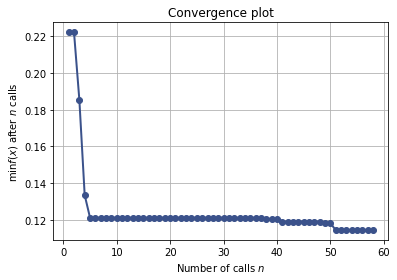

In [ ]:
# GRAFICOS 
plot_convergence(search_result)

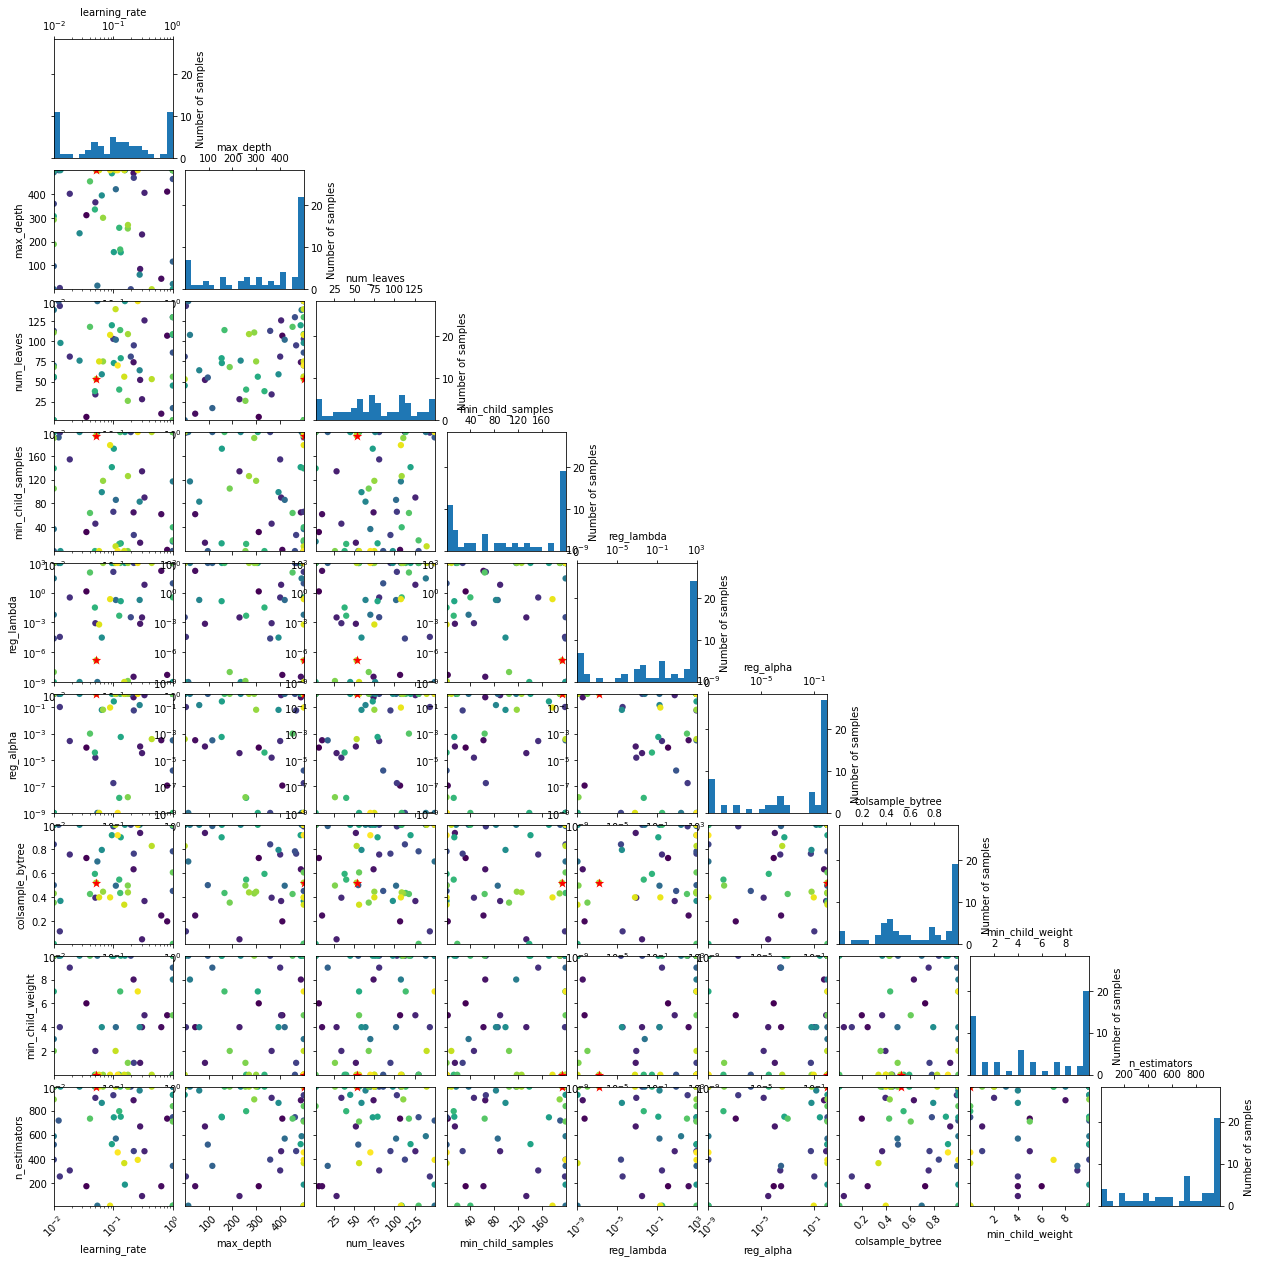

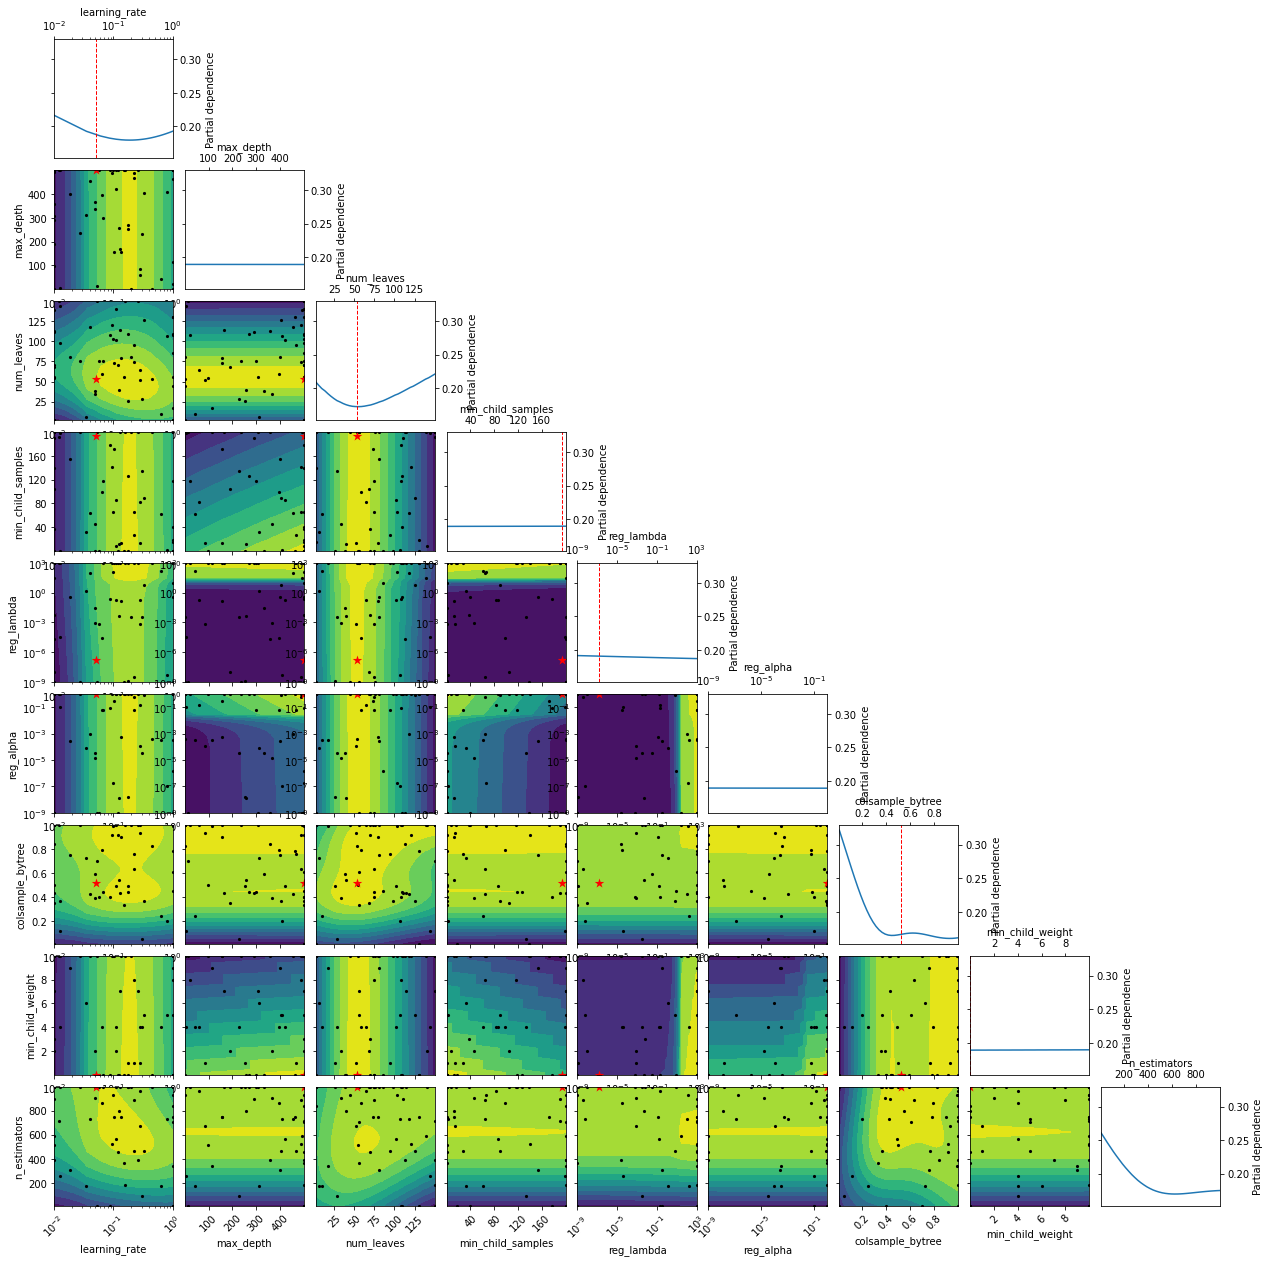

In [ ]:
ppE = plot_evaluations(search_result)
pp = plot_objective(search_result)

In [ ]:

model = LGBMRegressor(**best_parameters[0])

model.fit(X_train, y_train.reshape(-1), **fit_params)
y_pred_train, y_pred, y_pred_test = predicctionDesNormalizacion(model)

print('RMSE en train:',np.sqrt((((df_train['Sales'].values - y_pred_train)/df_train['Sales'].values)**2).sum()/len(y_pred_train)))
print('RMSE en val:', np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred)))

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionMonthsOpen', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'Events', 'Month', 'Promo2SinceYear', 'Promo2Weeks', 'PromoInterval', 'Promo_bw', 'Promo_fw', 'SchoolHoliday_bw', 'SchoolHoliday_fw', 'State', 'StateHoliday', 'StateHoliday_bool_bw', 'StateHoliday_bool_fw', 'Store', 'StoreType', 'Week', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE en train: 0.1562049837392428
RMSE en val: 0.11444368251580932


In [ ]:
 y_pred_train, y_pred, y_pred_test = predicctionDesNormalizacion(model)

In [ ]:
if not os.path.isfile('models.py'):
  sample_csv = pd.read_csv(googleDrivePath+'/dataset/sample_submission.csv')
else:
  sample_csv = pd.read_csv('./dataset/rossmann/sample_submission.csv')

sample_csv['Sales'] = y_pred_test
sample_csv.head()

if not os.path.isfile('models.py'):
  sample_csv.to_csv(googleDrivePath+f'/submision_{log_output}-{min_child_samples}-{n_estimators}-{learning_rate}.csv', index=False)
else:
  sample_csv.to_csv(f'submision_{log_output}-{min_child_samples}-{n_estimators}-{learning_rate}.csv', index=False)

####  LGBMRegressor y BayesSearchCV

In [ ]:
lightGBMSearchBayeCV = LGBMRegressor(n_jobs=8,verbose=1)
bayesSearchOptLightGBM = BayesSearchCV(lightGBMSearchBayeCV,
                    search_spacesBayesCV,
                    scoring='neg_root_mean_squared_error',
                    cv=4,
                    n_iter=max_iterSearch,
                    n_jobs=8,
                    return_train_score=False,
                    refit=True,
                    fit_params= fit_params,
                    random_state=22)
%time bayesCVLightGBMFit =  bayesSearchOptLightGBM.fit(X_train, y_train.reshape(-1))

KeyboardInterrupt: ignored

In [ ]:
print('best parameters:' bayesSearchOptLightGBM.best_params_)
print('best score':, bayesSearchOptLightGBM.best_score_)

In [ ]:
model = LGBMRegressor(learning_rate=0.010717, max_depth=1, num_leaves=60, 
                          min_child_samples=163,reg_lambda=280.438324, reg_alpha=0.000558,
                          colsample_bytree=0.259107, min_child_weight=3, n_estimators=731,n_jobs=8)
model.fit(X_train, y_train.reshape(-1), **fit_params)
y_pred_train, y_pred, y_pred_test = predicctionDesNormalizacion(model)

print('RMSE en train:',np.sqrt((((df_train['Sales'].values - y_pred_train)/df_train['Sales'].values)**2).sum()/len(y_pred_train)))
print('RMSE en val:', np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred)))

####  LGBMRegressor y HyperOpt

In [ ]:

def objective(params):
        
    clf = LGBMRegressor(**params)    
    score = -cross_val_score(clf, X_train.values, y_train.reshape(-1), cv=4, scoring='neg_root_mean_squared_error', verbose=1).mean()
    return score

tpe_trials = Trials()    


%time hyperOptLightGBM = fmin(fn=objective, space=search_HyperOptSearch, verbose=2, algo=hyperopt.tpe.suggest, max_evals=max_iterSearch)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



100%|██████████| 1/1 [01:20<00:00, 80.22s/it, best loss: 0.04015271468298643]


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min finished



In [ ]:
print('best parameters:', hyperOptLightGBM)

best parameters: {'colsample_bytree': 0.5335407356258479, 'learning_rate': 1.6246718221729706, 'max_depth': 316, 'min_child_samples': 125, 'min_child_weight': 8, 'n_estimators': 301, 'num_leaves': 31, 'reg_alpha': 1.7414551864149472, 'reg_lambda': 2.2057356532991548e+232}


In [ ]:
model = LGBMRegressor(**hyperOptLightGBM)
model.fit(X_train, y_train.reshape(-1), **fit_params)
y_pred_train, y_pred, y_pred_test = predicctionDesNormalizacion(model)

print('RMSE en train:',np.sqrt((((df_train['Sales'].values - y_pred_train)/df_train['Sales'].values)**2).sum()/len(y_pred_train)))
print('RMSE en val:', np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred)))

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionMonthsOpen', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'Events', 'Month', 'Promo2SinceYear', 'Promo2Weeks', 'PromoInterval', 'Promo_bw', 'Promo_fw', 'SchoolHoliday_bw', 'SchoolHoliday_fw', 'State', 'StateHoliday', 'StateHoliday_bool_bw', 'StateHoliday_bool_fw', 'Store', 'StoreType', 'Week', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE en train: 0.5609264880370579
RMSE en val: 0.48367124004717155


# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

# Sumbit a la competición

In [ ]:
sample_csv = pd.read_csv(r'./dataset/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{log_output}-{n_estimators}-{learning_rate}.csv', index=False)